In [1]:
print("loading dataset")
import kagglehub

loading dataset


In [2]:
# # Download latest version
# path = kagglehub.dataset_download("jigarpanjiyar/english-to-manipuri-dataset")

# print("Path to dataset files:", path)

In [3]:
import pandas as pd
import os

In [4]:
path = "/Users/shusanketbasyal/.cache/kagglehub/datasets/jigarpanjiyar/english-to-manipuri-dataset/versions/1"
os.listdir(path)

['1_Eng.txt', 'english-nepali.xlsx', '1_Nepali.txt']

In [5]:
df = pd.read_excel(path + "/english-nepali.xlsx")

In [6]:
df["english_sent"] = df["english_sent"].apply(lambda x: str(x))
df["nepali_sent"] = df["nepali_sent"].apply(lambda x: str(x))

In [7]:
eng = df["english_sent"].tolist()
nep = df["nepali_sent"].tolist()

In [8]:
df.head()

,english_sent,nepali_sent
0,"It happened after the death of Saul, when Davi...",दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शा...
1,"it happened on the third day, that behold, a m...",तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा आयो। त...
2,"David said to him, ""Where do you come from?"" H...","दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?” त्यस ..."
3,"David said to him, ""How did it go? Please tell...","दाऊदले भने, “मलाई भन, के भयो?” त्यसले भन्यो, “..."
4,"David said to the young man who told him, ""How...","दाऊदले त्यस सैनिकलाई भने, “तिमीले कसरी जान्यौ ..."


In [9]:
len(eng), len(nep)

(151937, 151937)

In [11]:
eng_lens = []
nep_lens = []
eng_com = []
nep_com = []
step = 8
for x in range(0, len(eng), step):
    engobj = " ".join(eng[x : x + step])
    nepobj = " ".join(nep[x : x + step])

    englen = len(engobj.split(" "))
    neplen = len(nepobj.split(" "))

    # we will have seq len of 256 for the transformer so making sure the
    # the length is less than 200
    # later in tokenizer one word will be converted to two.

    # if englen > 200 or neplen > 200:
    #     continue

    eng_com.append(engobj)
    eng_lens.append(englen)

    nep_com.append(nepobj)
    nep_lens.append(neplen)

In [12]:
len(eng_com)

18993

In [13]:
len(nep_com)

18993

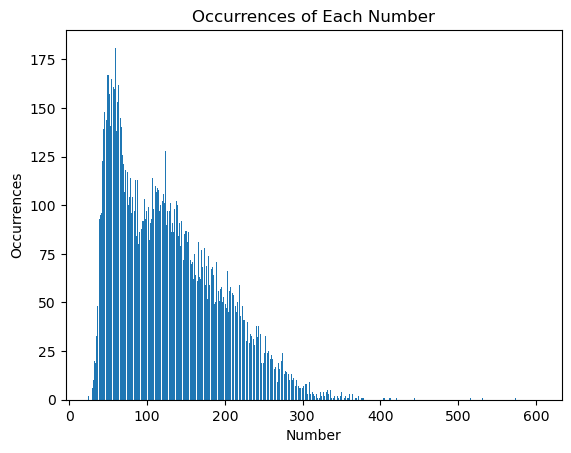

In [14]:
import matplotlib.pyplot as plt
from collections import Counter


# Count occurrences
counts = Counter(eng_lens)

# Extract unique numbers and their counts
x = list(counts.keys())
y = list(counts.values())

# Create the bar graph
plt.bar(x, y)
plt.xlabel("Number")
plt.ylabel("Occurrences")
plt.title("Occurrences of Each Number")
plt.show()

In [15]:
# eng_com, # nep_com, # eng_lens
len(eng_com), len(eng_lens)

(18993, 18993)

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.normalizers import Lowercase
from tokenizers.pre_tokenizers import Punctuation, Sequence, Whitespace


def build_load_tokenizer(lang, data):
    if lang == "eng":
        filename = "engtokenizer.json"
    elif lang == "nep":
        filename = "neptokenizer.json"
    else:
        return "Not recognized language. {lang}"

    if os.path.isfile(filename):
        # file exists
        tokenizer = Tokenizer.from_file(filename)
        return tokenizer

    else:

        tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
        trainer = WordLevelTrainer(
            special_tokens=["[UNK]", "[SOS]", "[PAD]", "[MASK]", "[EOS]"]
        )
        tokenizer.pre_tokenizer = Sequence([Whitespace(), Punctuation()])
        if lang == "eng":
            tokenizer.normalizer = Lowercase()
        tokenizer.train_from_iterator(data, trainer=trainer)
        tokenizer.save(filename)
        return tokenizer

In [16]:
len(eng_com), len(nep_com), len(eng), len(nep)

(18993, 18993, 151937, 151937)

In [ ]:
engtokenizer = build_load_tokenizer("eng", eng_com)

In [ ]:
engtokenizer.token_to_id("[SOS]")

In [ ]:
neptokenizer = build_load_tokenizer("nep", nep)

In [ ]:
from torch.utils.data import Dataset, random_split, DataLoader
import torch

In [ ]:
# create the dataset to pass to pytorch dataset
# eng_com and nep_com
trainlen = int(0.9 * len(eng_com))
data = {"eng": eng_com, "nep": nep_com}
df_raw = pd.DataFrame(data)

In [ ]:
len(df_raw)

In [ ]:
class CustomDataset(Dataset):

    # tgt and seq have
    def __init__(self, ds, src_tokenizer, tgt_tokenizer, src, tgt, seq_len):
        super().__init__()
        self.df = ds
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.src = src
        self.tgt = tgt
        self.seq_len = seq_len

        self.sos_token = torch.tensor(
            [src_tokenizer.token_to_id("[SOS]")], dtype=torch.int64
        )

        self.eos_token = torch.tensor(
            [src_tokenizer.token_to_id("[EOS]")], dtype=torch.int64
        )

        self.pad_token = torch.tensor(
            [src_tokenizer.token_to_id("[PAD]")], dtype=torch.int64
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # get a single instance
        src_target_pair = self.df.iloc[index]

        # extract src and tgt
        src_text = src_target_pair["eng"]
        tgt_text = src_target_pair["nep"]

        # encode the text to tokens
        enc_input_tokens = self.src_tokenizer.encode(src_text).ids
        dec_input_tokens = self.tgt_tokenizer.encode(tgt_text).ids

        # add padding tokens(subtracting 2 beacuse we add SOS, EOS)
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1

        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError("Sentence is too long")

        encoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(enc_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor(
                    [self.pad_token] * enc_num_padding_tokens, dtype=torch.int64
                ),
            ]
        )

        decoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                torch.tensor(
                    [self.pad_token] * dec_num_padding_tokens, dtype=torch.int64
                ),
            ]
        )

        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor(
                    [self.pad_token] * dec_num_padding_tokens, dtype=torch.int64
                ),
            ]
        )

        return {
            "encoder_input": encoder_input,
            "decoder_input": decoder_input,
            "label": label,
            # only mask padding token
            "encoder_mask": (encoder_input != self.pad_token).int(),
            "decoder_mask": (decoder_input != self.pad_token).int()
            & causal_mask(decoder_input.size(0)),
        }

    def causal_mask(size):
        x = torch.ones(size, size)
        x = torch.tril(x)
        return x

In [ ]:
train_ds = CustomDataset(df_raw, engtokenizer, neptokenizer, "eng", "nep", 512)
train_dataloader = DataLoader(train_ds, batch_size=12, shuffle=True)

In [ ]:
for x in train_dataloader:
    print(x["encoder_input"].shape)
    print(x["decoder_input"].shape)
    print(x["label"].shape)
    print(x["encoder_mask"].shape)
    print(x["decoder_mask"].shape)
    break

In [ ]:
text = df_raw.iloc[0]
testeng = text["eng"]
testnep = text["nep"]
testeng = testeng[0:50]
testnep = testnep[0:50]

In [ ]:
testeng

In [ ]:
testnep

In [ ]:
sostoken = engtokenizer.encode("[SOS]").ids
eostoken = engtokenizer.encode("[EOS]").ids
padtoken = engtokenizer.encode("[PAD]").ids
padtoken

In [ ]:
seq_len = 15

In [ ]:
encoderinput = engtokenizer.encode(testeng).ids
decoderinput = neptokenizer.encode(testnep).ids

In [ ]:
len(encoderinput), len(decoderinput)

In [ ]:
encoder_padd = seq_len - len(encoderinput) - 2
decoder_padd = seq_len - len(decoderinput) - 1

In [ ]:
encoder_input = torch.cat(
    [
        torch.tensor(sostoken),
        torch.tensor(encoderinput),
        torch.tensor(eostoken),
        torch.tensor(padtoken * encoder_padd),
    ]
)

decoder_input = torch.cat(
    [
        torch.tensor(sostoken),
        torch.tensor(decoderinput),
        torch.tensor(padtoken * decoder_padd),
    ]
)

label = torch.cat(
    [
        torch.tensor(decoderinput),
        torch.tensor(eostoken),
        torch.tensor(padtoken * decoder_padd),
    ]
)

encoder_mask = (encoder_input != torch.tensor(padtoken)).int()
decoder_mask = (decoder_input != torch.tensor(padtoken)).int() & causal_mask(
    decoder_input.shape[0]
)


def causal_mask(size):
    x = torch.ones(size, size, dtype=torch.int32)
    x = torch.tril(x)
    return x

In [ ]:
encoder_input.shape, decoder_input.shape, label.shape

In [ ]:
encoder_input

In [ ]:
encoder_mask

In [ ]:
encoder_mask.shape

In [ ]:
decoder_input

In [ ]:
decoder_mask

In [ ]:
cm = causal_mask(seq_len)

In [ ]:
decoder_mask.shape, cm.shape

In [ ]:
causal_mask(seq_len)

In [ ]:
decoder_mask

In [ ]:
encoder_input.shape, decoder_input.shape, label.shape, encoder_mask.shape, decoder_mask.shape